### Import Libraries & Modules

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits import mplot3d
import seaborn as sns
sns.set_theme()
import re
import string
from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')

import collections
from collections import Counter
import scipy.stats as stats

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# EDA

### Load Data

In [20]:
df = pd.read_csv('train.csv')

In [21]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [22]:
df.shape

(7613, 5)

In [23]:
df = df.drop('id',axis=1)

In [24]:
duplicate_dict = {}
for num, row in df[df['text'].duplicated()].iterrows():

    if row['text'] not in duplicate_dict:
        duplicate_dict[row['text']] = [row['target']]
    else:
        duplicate_dict[row['text']].append(row['target'])

In [25]:
opp_target = [] # this will be the list of all the tweets that are duplicated but got 0 label and 1 label also. we cannot tell if these are emergency or not
for k,v in duplicate_dict.items():
    if all(x == v[0] for x in v):
        pass
    else:
        opp_target.append(k)

In [26]:
index_list = []
for i in opp_target:
    for j in list(df[df['text'].str.contains(i)].index.values):
        index_list.append(j)

/usr/local/lib/python3.7/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [27]:
df.shape

(7613, 4)

In [28]:
df = df.drop(np.array(index_list), axis=0)
df.shape

(7580, 4)

In [29]:
df = df.drop_duplicates(subset = 'text', keep='first') # we remove 1 of each of the remaining duplicate pairs
df.shape

(7493, 4)

In [30]:
# percent/100 of missing values for each feature according to the label
df[df['target']==0].isna().sum()/len(df[df['target']==0]), df[df['target']==1].isna().sum()/len(df[df['target']==1])

(keyword     0.004419
 location    0.333488
 text        0.000000
 target      0.000000
 dtype: float64, keyword     0.011588
 location    0.326026
 text        0.000000
 target      0.000000
 dtype: float64)

In [31]:
nan_non_perc = 100*df[df['target']==0].isna().sum()/len(df[df['target']==0])
nan_non_perc

keyword      0.441860
location    33.348837
text         0.000000
target       0.000000
dtype: float64

In [32]:
nan_non = df[df['target']==0].isna().sum()
nan_non

keyword       19
location    1434
text           0
target         0
dtype: int64

In [33]:
nan_emer = df[df['target']==1].isna().sum()
nan_emer

keyword       37
location    1041
text           0
target         0
dtype: int64

In [34]:
nan_emer_perc = 100*df[df['target']==1].isna().sum()/len(df[df['target']==1])
nan_emer_perc

keyword      1.158785
location    32.602568
text         0.000000
target       0.000000
dtype: float64

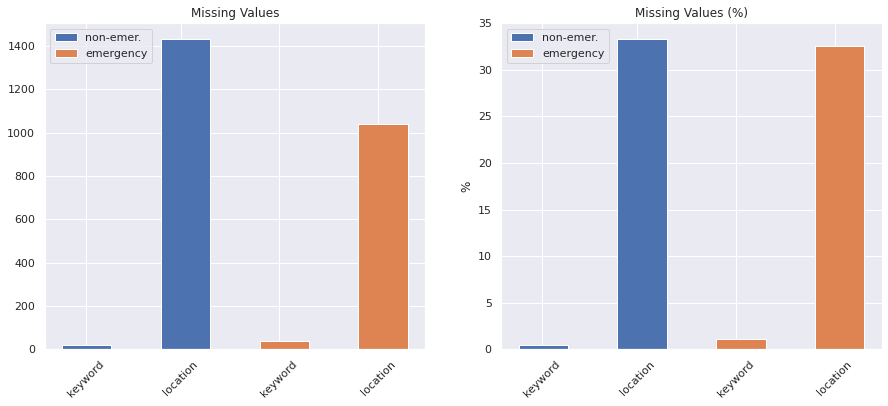

In [35]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.bar(x=[0,.5], height=[nan_non['keyword'], nan_non['location']], label='non-emer.',
       align='edge', width=.25)
plt.bar(x=[1,1.5], height=[nan_emer['keyword'], nan_emer['location']], label='emergency',
       align='edge', width=.25)
plt.legend()
plt.xticks([.12,.6,1.1,1.6], labels=['keyword', 'location','keyword', 'location'], rotation=45)
plt.legend(loc='upper left')
plt.title('Missing Values')

plt.subplot(1,2,2)
plt.bar(x=[0,.5], height=[nan_non_perc['keyword'], nan_non_perc['location']], label='non-emer.',
       align='edge', width=.25)
plt.bar(x=[1,1.5], height=[nan_emer_perc['keyword'], nan_emer_perc['location']], label='emergency',
       align='edge', width=.25)
plt.legend()
plt.xticks([.12,.6,1.1,1.6], labels=['keyword', 'location','keyword', 'location'], rotation=45)
plt.legend(loc='upper left')
plt.ylabel('%')
plt.title('Missing Values (%)')
plt.show()

In [36]:
# what to do with NaN values??

In [37]:
df[df['target']==0]['keyword'].dropna().shape[0] / len(df[df['target']==0])
# 99.5% of non emergency tweets have a keyword

0.9955813953488372

In [38]:
df[df['target']==0]['location'].dropna().shape[0] / len(df[df['target']==0])
# 66.4% of non emergency tweets have a location

0.6665116279069767

In [39]:
df[df['target']==1]['keyword'].dropna().shape[0] / len(df[df['target']==1])
# 98.7% of emergency tweets have a keyword

0.9884121515815847

In [40]:
df[df['target']==1]['location'].dropna().shape[0] / len(df[df['target']==1])
# 67.1% of emergency tweets have a location

0.6739743188224241

In [41]:
df_nan = pd.DataFrame({'missing_keyword':[len(df[df['target']==0]) - df[df['target']==0]['keyword'].dropna().shape[0],
                                len(df[df['target']==1]) - df[df['target']==1]['keyword'].dropna().shape[0]],
                       '%_keyword':[(len(df[df['target']==0]) - df[df['target']==0]['keyword'].dropna().shape[0])/len(df[df['target']==0]),
                                   (len(df[df['target']==1]) - df[df['target']==1]['keyword'].dropna().shape[0])/len(df[df['target']==1])],
             'missing_location':[len(df[df['target']==0]) - df[df['target']==0]['location'].dropna().shape[0],
                                len(df[df['target']==1]) - df[df['target']==1]['location'].dropna().shape[0]],
                       '%_location':[100*(len(df[df['target']==0]) - df[df['target']==0]['location'].dropna().shape[0])/len(df[df['target']==0]),
                                    (100*len(df[df['target']==1]) - df[df['target']==1]['location'].dropna().shape[0])/len(df[df['target']==1])],
             'target':['Non-emergency','Emergency']})
df_nan

,missing_keyword,%_keyword,missing_location,%_location,target
0,19,0.004419,1434,33.348837,Non-emergency
1,37,0.011588,1041,99.326026,Emergency


The table above summarized the NaNs we have divided by the target label. 

# Is the data balanced?

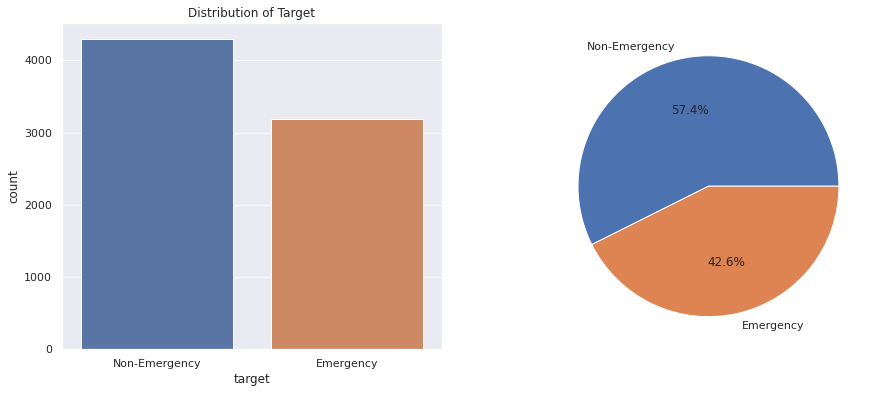

In [42]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.countplot(x=df['target'])
plt.xticks([0,1], ['Non-Emergency','Emergency'])
plt.title('Distribution of Target')

plt.subplot(1,2,2)
non_count = df[df['target']==0].shape[0]
emer_count = df[df['target']==1].shape[0]
plt.pie([non_count, emer_count], labels = ['Non-Emergency', 'Emergency'], autopct='%1.1f%%')

plt.show()

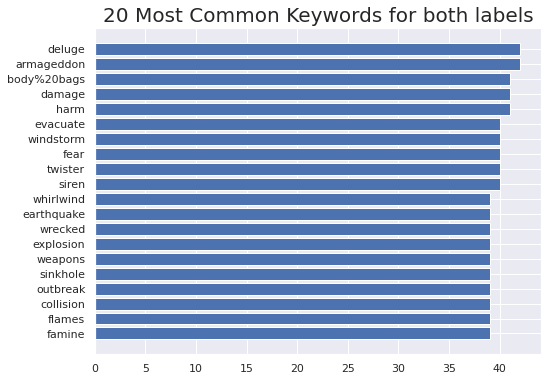

In [43]:
plt.figure(figsize=(8,6))
plt.barh(df['keyword'].value_counts()[20:0:-1].index, width=df['keyword'].value_counts()[20:0:-1])
plt.title('20 Most Common Keywords for both labels', fontsize=20)
plt.show()

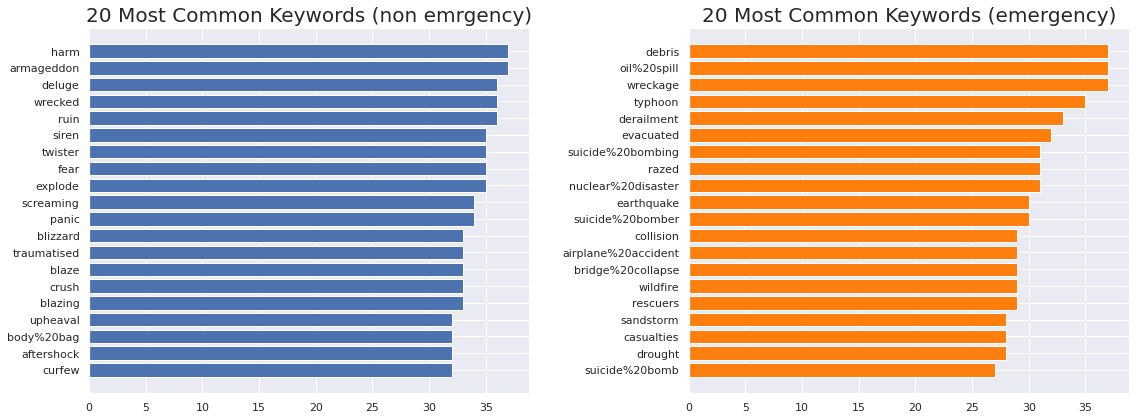

In [44]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.barh(df[df['target']==0]['keyword'].value_counts()[20:0:-1].index, 
         width=df[df['target']==0]['keyword'].value_counts()[20:0:-1])
plt.title('20 Most Common Keywords (non emrgency)', fontsize=20)

plt.subplot(1,2,2)
plt.barh(df[df['target']==1]['keyword'].value_counts()[20:0:-1].index, 
         width=df[df['target']==1]['keyword'].value_counts()[20:0:-1], color='tab:orange')
plt.title('20 Most Common Keywords (emergency)', fontsize=20)
plt.tight_layout()
plt.show()

In [45]:
unique_norm = set(df[df['target']==0]['keyword'].unique())
unique_emer = set(df[df['target']==1]['keyword'].unique())
intersect = unique_norm.intersection(unique_emer)

print('unique_norm', len(unique_norm))
print('unique_emer', len(unique_emer))
print('intersection', len(intersect))

unique_norm 219
unique_emer 221
intersection 218


### as you can see, the intersection contains 218 keywords hence this is a very bad indicator!

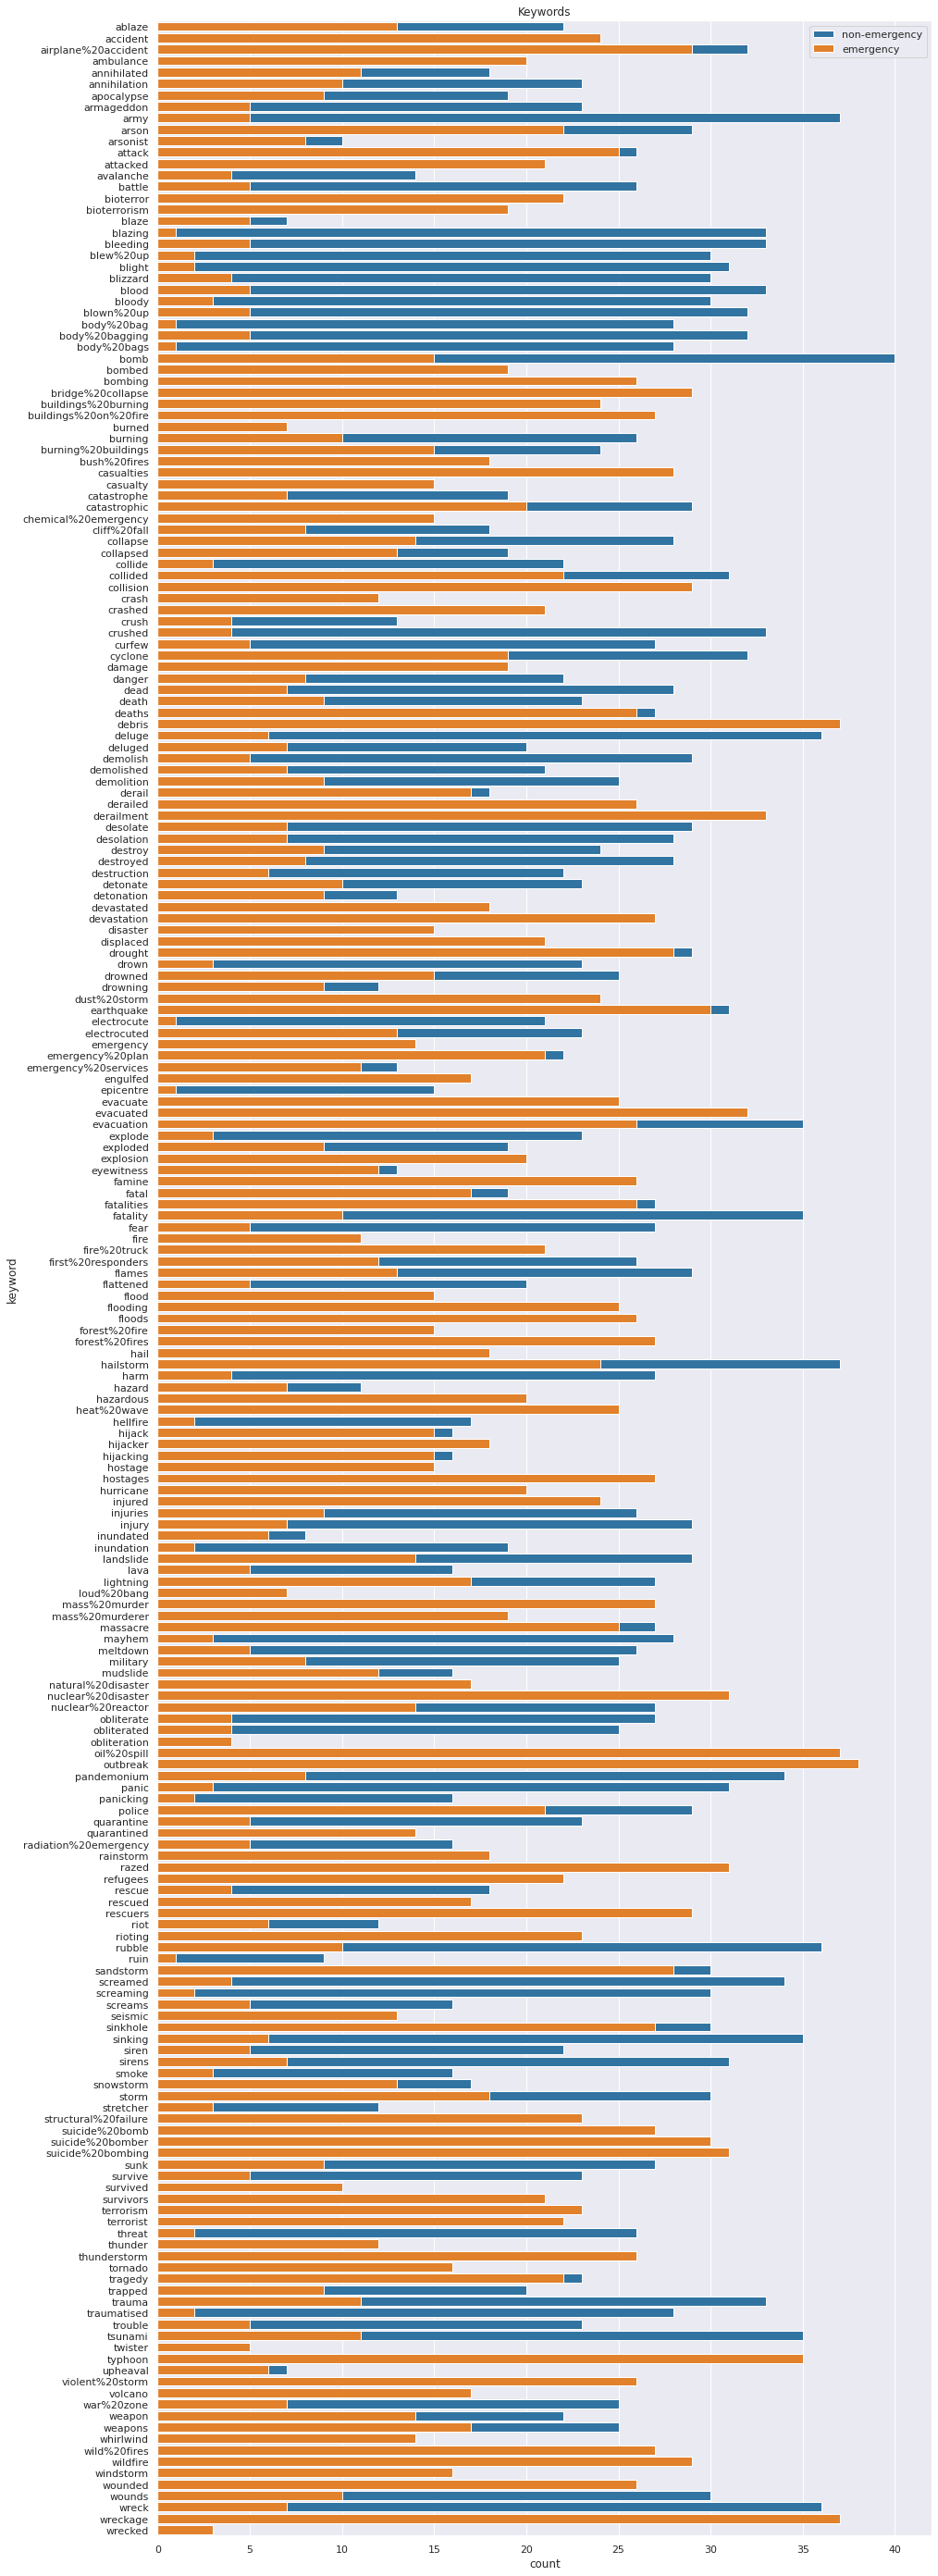

In [46]:
plt.figure(figsize=(15,50))
sns.countplot(y=df[df['target']==0]['keyword'], color='tab:blue', label='non-emergency')
sns.countplot(y=df[df['target']==1]['keyword'], color='tab:orange', label='emergency')
plt.legend()
plt.title('Keywords')
plt.show()

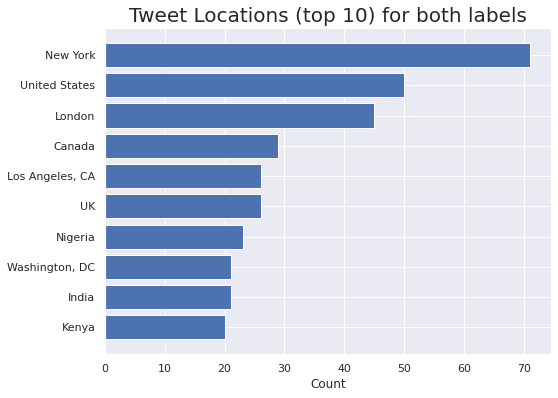

In [47]:
plt.figure(figsize=(8,6))
plt.barh(df['location'].value_counts().index[10:0:-1], df['location'].value_counts().values[10:0:-1])
plt.title('Tweet Locations (top 10) for both labels', fontsize=20)
plt.xlabel('Count')
plt.show()

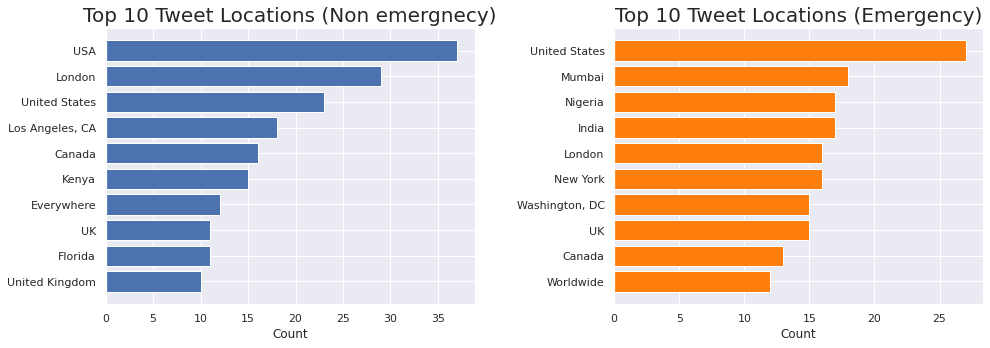

In [48]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.barh(df[df['target']==0]['location'].value_counts().index[10:0:-1], 
         df[df['target']==0]['location'].value_counts().values[10:0:-1])
plt.title('Top 10 Tweet Locations (Non emergnecy)', fontsize=20)
plt.xlabel('Count')

plt.subplot(1,2,2)
plt.barh(df[df['target']==1]['location'].value_counts().index[10:0:-1], 
         df[df['target']==1]['location'].value_counts().values[10:0:-1], color='tab:orange')
plt.title('Top 10 Tweet Locations (Emergency)', fontsize=20)
plt.xlabel('Count')

plt.tight_layout()
plt.show()

### problem with location: we have USA and United States as separate locations... also we have Los Angeles as a location also which is a city in the USA...

### Let's look at the length of a tweet and see if an emergency tweet is longer or shorter than non emergency

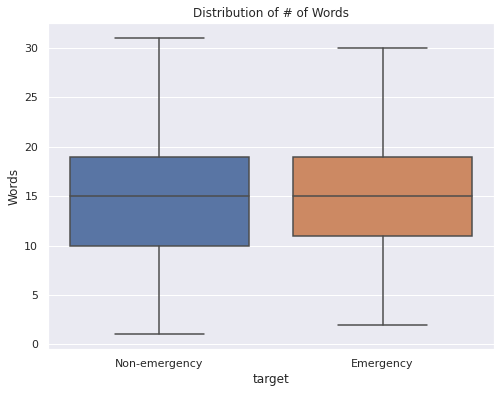

In [49]:
plt.figure(figsize=(8,6))
sns.boxplot(x = df['target'], y=df['text'].str.split().apply(lambda x: len(x)))
plt.title('Distribution of # of Words')
plt.xticks(ticks=[0,1],labels = ['Non-emergency', 'Emergency'])
plt.ylabel('Words')
plt.show()

In [50]:
stats.f_oneway(df[df['target']==0]['text'].str.split().apply(lambda x: len(x)),
               df[df['target']==1]['text'].str.split().apply(lambda x: len(x)))

F_onewayResult(statistic=12.209882824419227, pvalue=0.00047811839833139747)

### Since p_val < .05 we reject H0 and conclude there is difference in means. 
### kind of strange because according to the boxplot above it does not seem that way..

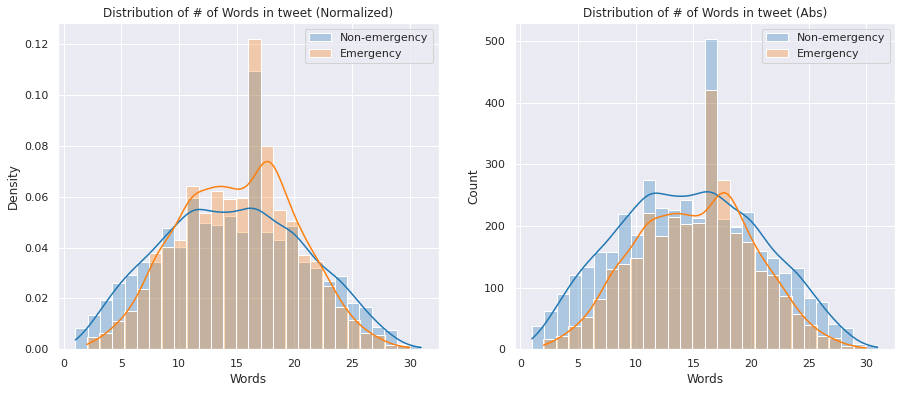

In [51]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.histplot(df[df['target']==0]['text'].str.split().apply(lambda x: len(x)), 
             kde=True, 
             stat='density',
            label='Non-emergency',
            alpha=.3, color='tab:blue')
sns.histplot(df[df['target']==1]['text'].str.split().apply(lambda x: len(x)), 
             kde=True, 
             stat='density',
            label='Emergency',
            alpha=.3, color='tab:orange')

plt.title('Distribution of # of Words in tweet (Normalized)')
plt.xlabel('Words')
plt.legend()

plt.subplot(1,2,2)
sns.histplot(df[df['target']==0]['text'].str.split().apply(lambda x: len(x)), 
             kde=True, 
            label='Non-emergency',
            alpha=.3, color='tab:blue')
sns.histplot(df[df['target']==1]['text'].str.split().apply(lambda x: len(x)), 
             kde=True, 
            label='Emergency',
            alpha=.3, color='tab:orange')
plt.xlabel('Words')
plt.title('Distribution of # of Words in tweet (Abs)')
plt.legend()


plt.show()

In [52]:
# number of words in a non emergency tweet:
words_non = df[df['target']==0]['text'].str.split().apply(lambda x: len(x)) 
# number of words in an emergency tweet:
words_emer = df[df['target']==1]['text'].str.split().apply(lambda x: len(x))

In [53]:
print('for a non emergency tweet:')
print(f'average number of words: {round(words_non.mean(), 2)}')
print(f'The variance is: {round(words_non.var(), 2)}')

for a non emergency tweet:
average number of words: 14.67
The variance is: 37.93


In [54]:
print('for an emergency tweet:')
print(f'average number of words: {round(words_emer.mean(), 2)}')
print(f'The variance is: {round(words_emer.var(), 2)}')

for an emergency tweet:
average number of words: 15.14
The variance is: 25.95


In [55]:
stats.ttest_ind(words_non, words_emer, equal_var=False)

Ttest_indResult(statistic=-3.5925185967693287, pvalue=0.00032962223139205597)

In [56]:
# normality test
stat, p = stats.shapiro(words_non)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.987, p=0.000
Sample does not look Gaussian (reject H0)


In [57]:
# normality test
stat, p = stats.shapiro(words_emer)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')


Statistics=0.991, p=0.000
Sample does not look Gaussian (reject H0)


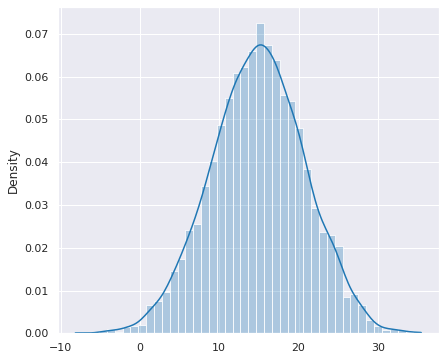

In [58]:
import math
mu, sigma = 15, math.sqrt(35) # mean and standard deviation
s = np.random.normal(mu, sigma, 4000)
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.histplot(s,
             kde=True,
             stat='density',
            label='normal dist',
            alpha=.3, color='tab:blue')

In [59]:
# normality test
stat, p = stats.shapiro(s)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=1.000, p=0.734
Sample looks Gaussian (fail to reject H0)


### checking the same for number of characters in tweets:
### Do emergency and non-emergency tweets have different number of characters?

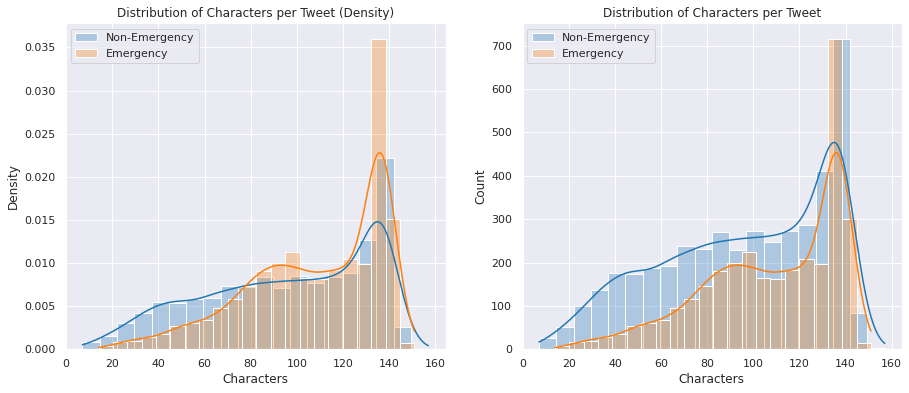

In [60]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.histplot(df[df['target']==0]['text'].str.len(), kde=True, label='Non-Emergency', alpha=.3, color='tab:blue',
            stat='density')
sns.histplot(df[df['target']==1]['text'].str.len(), kde=True, label='Emergency', alpha=.3, color='tab:orange',
            stat='density')
plt.title('Distribution of Characters per Tweet (Density)')
plt.xlabel('Characters')
plt.legend()

plt.subplot(1,2,2)
sns.histplot(df[df['target']==0]['text'].str.len(), kde=True, label='Non-Emergency', alpha=.3, color='tab:blue')
sns.histplot(df[df['target']==1]['text'].str.len(), kde=True, label='Emergency', alpha=.3, color='tab:orange')
plt.title('Distribution of Characters per Tweet')
plt.xlabel('Characters')
plt.legend()
plt.show()

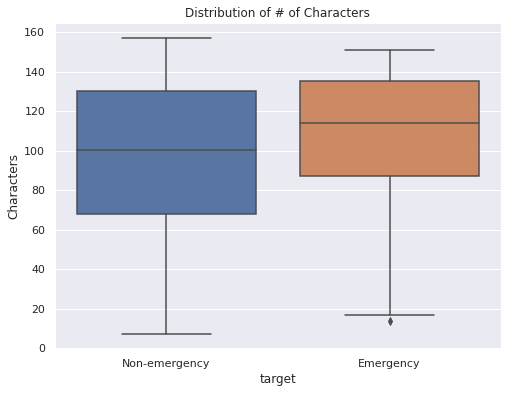

In [61]:
plt.figure(figsize=(8,6))
sns.boxplot(x = df['target'], y=df['text'].str.len())
plt.title('Distribution of # of Characters')
plt.xticks(ticks=[0,1],labels = ['Non-emergency', 'Emergency'])
plt.ylabel('Characters')
plt.show()

In [62]:
stats.f_oneway(df[df['target']==0]['text'].str.len(),
               df[df['target']==1]['text'].str.len())

F_onewayResult(statistic=255.47201689991553, pvalue=1.4249317494171995e-56)

### Since p_val < .05 --> reject Null and conclude there is difference in means

### Preprocessing

### Remove stop words

In [63]:
stop_words = stopwords.words('english') + ['u', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']

In [64]:
import spacy
nlp = spacy.load('en_core_web_sm')
import re
import string
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = ''.join([c for c in text if c not in string.punctuation])
    tokens = re.split('\W+', text)
    text = ' '.join([word for word in tokens if word not in stop_words])
    text = nlp(text)
    text = ' '.join([word.lemma_ for word in text])
    return text

In [65]:
df1 = df.drop(['keyword', 'location'], axis =1)
pd.set_option('display.max_colwidth', None)
df1.head()

,text,target
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,"13,000 people receive #wildfires evacuation orders in California",1
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [66]:
df1['clean text'] = df1['text'].apply(lambda x: clean_text(x))

In [67]:
df1.head()

,text,target,clean text
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,deeds reason earthquake may allah forgive -PRON-
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,resident ask shelter place notify officer evacuation shelter place order expect
3,"13,000 people receive #wildfires evacuation orders in California",1,people receive wildfire evacuation order california
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,get send photo ruby alaska smoke wildfires pour school


### Split data

In [68]:
X_train, X_test, y_train, y_test = train_test_split(df1['clean text'], df1['target'], test_size=.2, random_state=1)

### BOW

In [69]:
max_feat = 9000
cv = CountVectorizer(max_features = max_feat, ngram_range=(1,5), stop_words='english')

In [70]:
X_bow_train= cv.fit_transform(X_train)
X_bow_test = cv.transform(X_test)
y_bow_train = y_train
y_bow_test = y_test

In [71]:
X_bow_train.shape, X_bow_test.shape

((5994, 9000), (1499, 9000))

### TF-IDF

In [72]:
tf = TfidfVectorizer(max_features=9000, ngram_range=(1,5) ,stop_words='english')
X_tf_train= tf.fit_transform(X_train)
X_tf_test = tf.transform(X_test)
y_tf_train = y_train
y_tf_test = y_test


In [73]:
X_tf_train.shape

(5994, 9000)

# Baseline Models

### Random Guess

In [74]:
dc_freq = DummyClassifier(strategy = 'most_frequent')  
dc_freq.fit(X_bow_train, y_bow_train)
rand_pred_freq = dc_freq.predict(X_bow_test)

In [75]:
random_acc_freq = accuracy_score(y_bow_test, rand_pred_freq)  # doesn't matter if its bow or tf
random_acc_freq

0.5690460306871248

In [76]:
dc_strat = DummyClassifier(strategy = 'stratified')
dc_strat.fit(X_bow_train, y_bow_train)
rand_pred_strat = dc_strat.predict(X_bow_test)

In [77]:
random_acc_strat = accuracy_score(y_bow_test, rand_pred_strat)  # doesn't matter if its bow or tf
random_acc_strat

0.5056704469646431

## Baseline accuracy according to dummy classifier

In [78]:
# initialise data of lists.
data = {'Strategy':['most frequent', 'stratified'],
        'Accuracy':[random_acc_freq, random_acc_strat]}
 
# Create DataFrame
df_dc = pd.DataFrame(data)
 
# Print the output.
df_dc.set_index('Strategy')

,Accuracy
Strategy,
most frequent,0.569046
stratified,0.505670


# Metrics achieved by simple models:

In [79]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB

In [80]:
### Metrics using BOW:

In [81]:
clfs = [DummyClassifier(strategy = 'stratified'),
        RandomForestClassifier(), 
       AdaBoostClassifier(),
       LogisticRegression(),
       GaussianNB(),
        BernoulliNB()
       ]
res_df = pd.DataFrame(columns=['clf', 'Accuracy', 'Precision', 'Recall'])
for clf in clfs:
    scoring = ['accuracy', 'precision', 'recall']
    final_score = cross_validate(clf, X_bow_train.toarray(), y_bow_train, cv=5, scoring=scoring)
    res_df = res_df.append({'clf':clf.__class__.__name__, 
                            'Accuracy':final_score['test_accuracy'].mean(),
                           'Precision':final_score['test_precision'].mean(),
                           'Recall':final_score['test_recall'].mean()}, ignore_index=True)
res_df

,clf,Accuracy,Precision,Recall
0,DummyClassifier,0.507507,0.420868,0.424029
1,RandomForestClassifier,0.767772,0.753319,0.674917
2,AdaBoostClassifier,0.737071,0.774693,0.538666
3,LogisticRegression,0.787958,0.796822,0.672165
4,GaussianNB,0.745747,0.779875,0.559867
5,BernoulliNB,0.756760,0.910679,0.473889


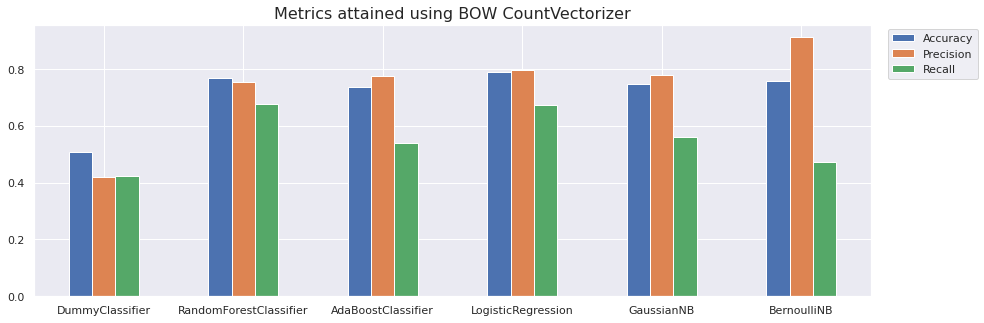

In [82]:
res_df.plot.bar(rot=0, figsize=(15,5))
plt.xticks([0, 1, 2, 3, 4, 5], res_df.clf)
plt.legend(loc=(1.02, 0.8))
plt.title('Metrics attained using BOW CountVectorizer', fontsize=16)
plt.show()

### Metrics using TF-IDF

In [83]:
clfs = [DummyClassifier(strategy = 'stratified'),
        RandomForestClassifier(), 
       AdaBoostClassifier(),
       LogisticRegression(),
       GaussianNB(),
        BernoulliNB()
       ]
res_df_tf = pd.DataFrame(columns=['clf', 'Accuracy', 'Precision', 'Recall'])
for clf in clfs:
    scoring = ['accuracy', 'precision', 'recall']
    final_score = cross_validate(clf, X_tf_train.toarray(), y_tf_train, cv=5, scoring=scoring)
    res_df_tf = res_df_tf.append({'clf':clf.__class__.__name__, 
                            'Accuracy':final_score['test_accuracy'].mean(),
                           'Precision':final_score['test_precision'].mean(),
                           'Recall':final_score['test_recall'].mean()}, ignore_index=True)
res_df_tf

,clf,Accuracy,Precision,Recall
0,DummyClassifier,0.497497,0.408218,0.403610
1,RandomForestClassifier,0.775613,0.791968,0.639970
2,AdaBoostClassifier,0.733234,0.787769,0.510803
3,LogisticRegression,0.792462,0.828086,0.645456
4,GaussianNB,0.738073,0.749581,0.576363
5,BernoulliNB,0.756760,0.910679,0.473889


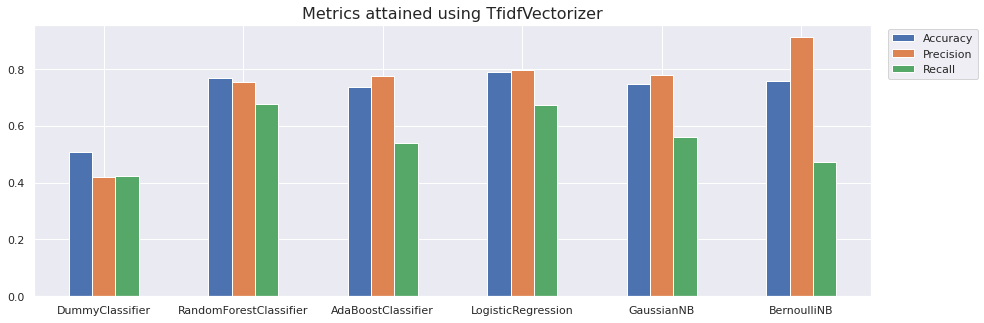

In [84]:
res_df.plot.bar(rot=0, figsize=(15,5))
plt.xticks([0, 1, 2, 3, 4, 5], res_df.clf)
plt.legend(loc=(1.02, 0.8))
plt.title('Metrics attained using TfidfVectorizer', fontsize=16)
plt.show()

### The metrics are pretty much the same using BOW or TF-IDF vectorization.

## saving a logistic regression model for deployment using Heroku

In [85]:
log_reg = LogisticRegression()
final_score = cross_validate(log_reg, X_tf_train.toarray(), y_tf_train, cv=5, scoring='accuracy')
final_score['test_score'].mean()

0.7924622772733538

In [86]:
log_reg.fit(X_tf_train.toarray(), y_tf_train)
pred = log_reg.predict(X_tf_test.toarray())
log_reg.score(X_tf_test.toarray(), y_tf_test)

0.7958639092728486

In [87]:
pred_proba = log_reg.predict_proba(X_tf_test.toarray())
pred_proba

array([[0.41321321, 0.58678679],
       [0.73879284, 0.26120716],
       [0.6118659 , 0.3881341 ],
       ...,
       [0.86082609, 0.13917391],
       [0.75259301, 0.24740699],
       [0.31212023, 0.68787977]])

In [88]:
import pickle
filename = 'logistic_model.pkl'
pickle.dump(log_reg, open(filename, 'wb'))


In [89]:
filename1 = 'tf.pkl'
pickle.dump(tf, open(filename1, 'wb'))